In [1]:
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.colors as mcolors
from datetime import datetime
import pandas as pd

# Initial Set-Up

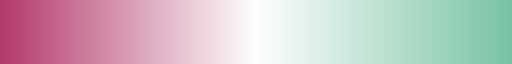

In [2]:
colors = ['#003DA6', '#B53A6D', '#7AC4A5', '#F17F4C', '#15AFD0', '#E5BF21']

basefont = mpl.font_manager.FontProperties(family='Times New Roman', style='normal', size=14)
mpl.rcParams['axes.titlesize'] = 14

plot_style = {
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.spines.left': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'axes.facecolor': 'w',
    'axes.edgecolor': 'black',
    'grid.color': '#aaaaaa',
    'grid.linewidth': '0.8',
    'grid.linestyle': '-',
    'axes.titlesize': 14,
    'legend.framealpha': 1.0,
    'errorbar.capsize': 8
}

plt.rcParams.update(plot_style)


def hex_to_rgb(hex):
    rgb = tuple(int(hex[i:i+2], 16) for i in range(1, 7, 2))
    return [v / 256 for v in rgb]


# NOTE: This function was taken from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
# Thank you to the author, Kerry Halupka! 
def get_continuous_cmap(hex_list):
    rgb_list = [hex_to_rgb(i) for i in hex_list]
    float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


get_continuous_cmap([colors[1], '#FFFFFF', colors[2]])

# Parameter Estimation

In [3]:
# Set a seed and some general variables
np.random.seed(42)
N_SIMS = 10000

# Initialize random values for w, L, IC, alpha, and P (penalty)
w = np.random.uniform(1.41, 9.53, size = N_SIMS)
L = np.random.uniform(5, 25, size = N_SIMS)
IC = np.random.uniform(0.0006, 0.024, size = N_SIMS)
alpha = np.random.uniform(2, 10, size = N_SIMS)
penalty = np.random.uniform(0.5, 2, size = N_SIMS) * w

# Also initialize random arrays for p and n
p = np.arange(0.1, 1.005, step = 0.005)
n = np.arange(0, 1e7 + 1e7 // 500, step = 1e7 // 500)
print('Number of values of p:', p.shape)
print('Number of values of n:', n.shape)

Number of values of p: (181,)
Number of values of n: (501,)


# Section 3: Human-Machine Teams with Unrestricted AI Access

1. Calculate, for all 10,000 samples, the marginal cost of an output for a human.
2. Then calculate, for each sample AND for varying values of p, the marginal cost of an output for a human-machine team. 
3. Create a figure (Figure 1) showing per-output savings as a function of p across many samples. 
4. Create a figure (Figure 2) multiplying the average savings per output for various values of p times various campaign sizes and visualizing the results.

In [4]:
# Calculate the costs of a marginal output for a marginal campaign
manual_mc = (w / L).reshape(N_SIMS, 1)
manual_mc.shape

(10000, 1)

In [5]:
# Calculate the costs of a marginal output for an unmonitored campaign
unmonitored_mc = (w / (alpha * L) + IC).reshape(N_SIMS, 1) / p.reshape(1, p.shape[0])
unmonitored_mc.shape

(10000, 181)

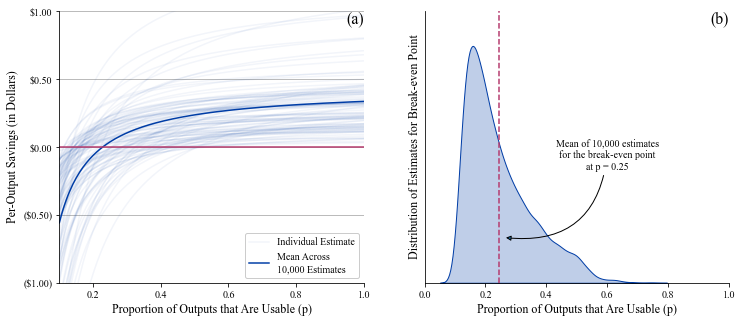

In [6]:
# Create a plot for Figure 1
fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (12,5))

# Calculate the marginal savings across all 10,000 samples at various values of p
savings = (manual_mc - unmonitored_mc)

# Randomly select 100 of those samples and plot how the savings changes for various values of p
for i, sim in enumerate(savings[np.random.choice(savings.shape[0], size = (100,), replace = False)]):
    if i == 0:
        ax0.plot(p, sim, alpha = 0.05, color = colors[0], label = 'Individual Estimate')
    else: 
        ax0.plot(p, sim, alpha = 0.05, color = colors[0])

# Then plot the mean savings per output for each value of p
ax0.plot(p, np.mean(savings, axis = 0), color = colors[0], label = 'Mean Across\n10,000 Estimates')
ax0.plot([0., 1.], [0., 0.], color = colors[1])
ax0.annotate("(a)", xy=(1, 1), xycoords='axes fraction', ha = 'right', va = 'top', fontsize = 16, fontname = 'Times New Roman')


# On the other plot, create a density plot of the breakeven point across all 10,000 parameter estimates
breakevens = 1 / alpha + L * IC / w  # From eq. 1
sns.kdeplot(breakevens, color = colors[0], fill = True, levels = [0.25, 0.5, 0.75], ax = ax1)
ax1.plot([np.mean(breakevens), np.mean(breakevens)], [0, 6], color = colors[1], linestyle = '--')
ax1.annotate(f"Mean of 10,000 estimates\nfor the break-even point\nat p = {round(np.mean(breakevens), 2)}", 
    xy=(np.mean(breakevens) + 0.015, 1), xytext=(0.6, 2.5), ha='center', arrowprops=dict(arrowstyle='-|>', 
    connectionstyle='arc3,rad=-0.5'), fontsize = 10, fontname = 'Times New Roman')
ax1.annotate("(b)", xy=(1, 1), xycoords='axes fraction', ha = 'right', va = 'top', fontsize = 16, fontname = 'Times New Roman')


# Adjust figure aesthetics affecting both plots
for ax, start in zip([ax0, ax1], [0.1, 0.]):
    ax.set_xticks(np.arange(0., 1.2, step = 0.2))
    ax.set_xticklabels([str(round(i, 1)) for i in np.arange(0., 1.2, step = 0.2)], fontsize = 10, fontname = 'Times New Roman')
    ax.set_xlabel('Proportion of Outputs that Are Usable (p)', fontsize = 12, fontname = 'Times New Roman')
    ax.set_xlim([start, 1.])  # x-axis starts at 0.1 on the right, at 0 on the left

# Adjust aesthetics affecting only the left-hand plot
ax0.set_ylim([-1, 1.])
ax0.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax0.set_yticklabels(['($1.00)', '($0.50)', '$0.00', '$0.50', '$1.00'], fontsize = 10, fontname = 'Times New Roman')
ax0.set_ylabel('Per-Output Savings (in Dollars)', fontsize = 12, fontname = 'Times New Roman')
ax0.legend(prop = mpl.font_manager.FontProperties(family='Times New Roman', style='normal', size=10))

# Adjust aesthetics affecting only the right-hand plot
ax1.set_ylabel('Distribution of Estimates for Break-even Point', fontsize = 12, fontname = 'Times New Roman')
ax1.set_yticks([])
ax1.set_ylim([0, 6])

# Save and display the figure
plt.savefig('figures/p.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/p.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [7]:
# Calculate the mean costs for manual and unmonitored AI campaigns, for various values of n and p
mean_manual = np.mean(manual_mc, axis = 0).reshape(-1, 1) * n.reshape(1, -1)
mean_unmonitored = np.mean(unmonitored_mc, axis = 0).reshape(-1, 1) * n.reshape(1, -1)

# Also calculate the relative savings from the unmonitored campaign
mean_savings = mean_manual - mean_unmonitored
mean_savings.shape

(181, 501)

In [8]:
# Create a function to draw boundary lines as shown in Figure 2
def find_boundary(matrix, thresh, reverse = False):
  x = []
  y = []

  # We exclude the first column to avoid divide by zero errors
  for i, row in enumerate(matrix[::-1, 1:]):

    # If there is at least one point at which cost savings exceed thresh for a model with this performance...
    if len(np.where(row > thresh)[0]) > 0:
      j = np.where(row > thresh)[0][0]

      # ...and that point is different than the last x value we added, then add this point to our list of boundary points
      if len(x) == 0 or j > x[-1]:
        y.append(i)
        x.append(j)

    # If there isn't a point where thresh is exceeded in this row, then just approximate the tail end of the curve with a straight line to the right axis and exit
    else:
      y.append(i-1)
      x.append(matrix.shape[1]-1)
      break

  return x, y

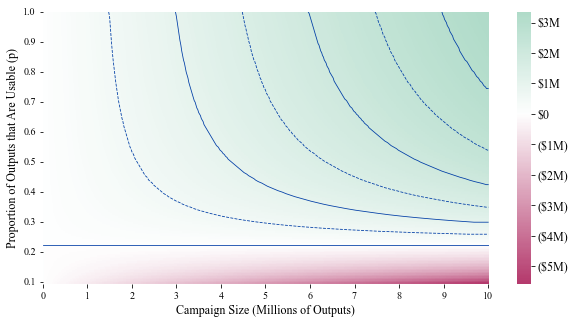

In [9]:
# Create a figure for Figure 2
fig, ax = plt.subplots(figsize = (10,5))

# Create a colormap for shading in the figure
cmap = get_continuous_cmap([colors[1], '#FFFFFF', colors[2]])

# Plot the savings as a heatmap, reversing the order of the y-axis (because sns.heatmap plots downward from the top of the axis by default)
sns.heatmap(mean_savings[::-1], ax = ax, cmap = cmap, vmin = np.min(mean_savings), vmax = np.max(mean_savings), center = 0)

# Find the boundary lines for increments of savings every $500,000 and plot them
for i, threshold in enumerate(range(int(5e5), 4 * int(1e6), int(5e5))):
  x, y = find_boundary(mean_savings, threshold)
  linestyle = '--' if i % 2 == 0 else '-'
  ax.plot(x, y, color = colors[0], linewidth = 0.8, linestyle = linestyle)

# Plot the breakeven line (which corresponds to a constant value of p)
intercept = mean_savings.shape[0] - np.where(mean_savings[:, -1] > 0)[0][0]
ax.plot([0, 1000], [intercept, intercept], color = colors[0], linewidth = 0.8)

# Label the color bar
ax.collections[0].colorbar.set_ticks([-5e6, -4e6, -3e6, -2e6, -1e6, 0, 1e6, 2e6, 3e6])
ax.collections[0].colorbar.set_ticklabels(['($5M)', '($4M)', '($3M)', '($2M)', '($1M)', '$0', '$1M', '$2M', '$3M'], fontsize = 12, fontname = 'Times New Roman')

# Adjust the figure aesthetics
ax.set_yticks(np.arange(0, p.shape[0], step = p.shape[0] // 9))
ax.set_yticklabels(['1.0','0.9','0.8','0.7','0.6','0.5','0.4','0.3','0.2','0.1'], fontsize = 10, fontname = 'Times New Roman')
ax.set_ylabel('Proportion of Outputs that Are Usable (p)', fontsize = 12, fontname = 'Times New Roman')
ax.set_xticks(np.arange(0, n.shape[0], step = n.shape[0] // 10))
ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], rotation=0, fontsize = 10, fontname = 'Times New Roman')
ax.set_xlabel('Campaign Size (Millions of Outputs)', fontsize = 12, fontname = 'Times New Roman')

# Save and display the figure
plt.savefig('figures/cumulative_savings.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

"If influence operators had unrestricted access to an LLM capable of producing usable text at least 75% of the time, this
model predicts that an operator could save upwards of $3 million over the course of a 10-million tweet campaign, with
an expected reduction in per-output content generation costs over 67%."

In [10]:
per_output_savings = np.mean(w / L - (w / (alpha * L) + IC) / 0.75)
total_savings = per_output_savings * 10e6
pct_savings = np.mean((w / L - (w / (alpha * L) + IC) / 0.75) / (w / L))

print(f'Total savings over a 10-million-tweet campaign: ${round(total_savings, 2)}')
print(f'Savings as a percent reduction in costs: {round(100 * pct_savings, 2)}%')

Total savings over a 10-million-tweet campaign: $3016250.41
Savings as a percent reduction in costs: 67.24%


# Section 4: Monitoring Controls on AI Models

1. For various detection rates and a few specified values of p, estimate the number of detections over a 10-million-tweet campaign.
2. Then estimate the penalties imposed by those detections and find the points at which potential savings from the use of an LLM are fully saturated and the propagandist switches back to manual authorship.
3. Plot (Figure 3) the cost imposition of monitoring controls as a function of detection capabilities, for four pre-specified values of p.

In [11]:
# Let detection range from perfect detection to one detection per 100,000 outputs
detection_rate = (1 / 10 ** np.arange(0, 5.1, step = 0.1)).reshape(1, -1)
print('Shape of detection_rate:', detection_rate.shape)


# Then, assuming a 10 million output campaign with p = 0.5, randomly sample the number of detections for various detection rates 10,000 times
def simulate_detections(temp_p = 0.5, temp_n = 1e7):
    return np.random.poisson(detection_rate * temp_n / temp_p, size = (N_SIMS, detection_rate.shape[1]))


# Calculate the total costs imposed by monitoring for these 10,000 samples, and for varying detection capabilities
def simulate_penalties(temp_p = 0.5, temp_n = 1e7):
    penalty_costs = penalty.reshape(-1, 1) * simulate_detections(temp_p, temp_n)

    # BUT penalty costs cannot go higher than the potential savings coming from the use of AI in the first place
    # (And this maximum value can be found in the `savings` array at the point where p = temp_p)
    max_penalty_cost = savings[:, np.where(p >= temp_p)[0][0]].reshape(-1, 1) * temp_n
    penalty_costs = np.minimum(penalty_costs, max_penalty_cost)

    # AND if the savings themselves are negative, this means that the propagandist would not use AI in the first place
    # Which then means that "penalty_costs" of monitoring controls on the AI should be $0
    return np.maximum(penalty_costs, 0.)


# NOTE: the following two functions are not used to produced the following figure but can be used to visualize other ways of examining the samples
# Calculate percentage by which operating costs are increased from the use of monitoring controls
def calc_pct_increase(temp_p = 0.5, temp_n = 1e7):
    baseline_costs = (unmonitored_mc[:, np.where(p >= temp_p)[0][0]] * temp_n).reshape(-1, 1)
    return simulate_penalties(temp_p, temp_n) / baseline_costs


# Calculate the percent of potential savings removed by the use of monitoring controls
def calc_savings_denied(temp_p = 0.5, temp_n = 1e7):
    max_penalties = savings[:, np.where(p >= temp_p)[0][0]].reshape(-1, 1) * temp_n
    return simulate_penalties(temp_p, temp_n) / max_penalties

Shape of detection_rate: (1, 51)


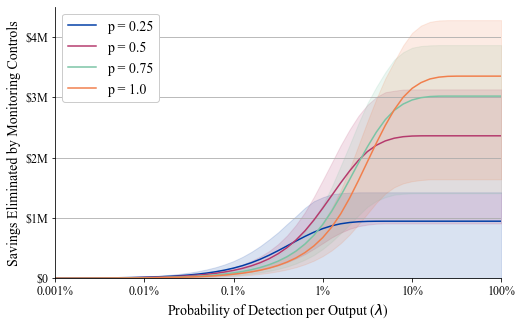

In [12]:
# Create a plot for Figure 3
fig, ax = plt.subplots(figsize = (8,5))

# For various values of p...
for i, p_ in enumerate([0.25, 0.5, 0.75, 1.0]):

    # ...use the functions in the preceding block to simulate total penalties of each simulated campaign
    # (Sorting the data does not affect the calculation of the mean across all samples, but allows for easy plotting of confidence intervals)
    simulated_data = np.sort(simulate_penalties(temp_p = p_), axis = 0)

    # Plot the mean penalties as a function of detection accuracy
    ax.plot(np.arange(5., -0.1, step = -0.1), np.mean(simulated_data, axis = 0), color = colors[i], label = f'p = {p_}')

    # Shade in an 80% confidence interval
    ax.fill_between(np.arange(5., -0.1, step = -0.1), simulated_data[N_SIMS // 4, :], simulated_data[-N_SIMS // 4, :], alpha = 0.15, color = colors[i])

# Adjust figure aesthetics for the left-hand figure
#ax.set_yscale('log')
ax.set_xlabel(f'Probability of Detection per Output ($\lambda$)', fontsize = 14, fontname = 'Times New Roman')
ax.set_yticks([0., 1e6, 2e6, 3e6, 4e6, 5e6])
ax.set_ylim([0., 4.5e6])
ax.set_yticklabels(['$0', '$1M', '$2M', '$3M', '$4M', '$5M'], fontsize = 12, fontname = 'Times New Roman')
ax.set_ylabel('Savings Eliminated by Monitoring Controls', fontsize = 14, fontname = 'Times New Roman')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xlim([0., 5.])
ax.set_xticklabels(['0.001%', '0.01%', '0.1%', '1%', '10%', '100%'], fontsize = 12, fontname = 'Times New Roman')
ax.legend(prop=basefont)

# Save and display the figure
plt.savefig('figures/detection_penalties.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Section 5: The Value of Monitoring when Public Models Are Accessible

1. Work through some algebraic manipulation regarding the minimum detection rate necessary to deter use of an API-gated model and the corresopnding cost imposition for various values of p1 and p2 (also provided in Appendix A). 
2. Write functions that can take a value of p1 and a value of p2 and calulate the minimum detection rate to deter use of the API model (and their corresponding cost imposition). 
3. Calculate the relevant values for values of (p1, p2) that can tile the possibility space.
4. Plot the possibility space (Figure 4) with corresponding detection rates and cost imposition for each tile.

### Algebraic manipulation

Figure 4 requires some extra algebraic manipulation not included in the text of the draft, which I have put here instead.

When an operator can choose between the use of a private, monitored model, the use of a public, unmonitored model, or reliance on a manual operation, there are four potential outcomes that may apply:

<ol>
    <li> The operator prefers the manual campaign to the use of either model (i.e., neither model performs well enough to be cost-effective);</li>
    <li> The operator prefers to use the public model (i.e., the public model performance is cost-effective and greater than the private model's performance);</li>
    <li> The operator prefers to use the private model, but would resort to the use of the public model if the costs from monitoring became sufficiently onerous; or</li>
    <li> The operator prefers to use the private model, and would resort to a manual campaign if the costs from monitoring became sufficiently onerous (i.e. the public model does not perform well enough to be cost-effective).
</ol>

Let $\hat{p}$ represent the performance threshold at which a model becomes cost-effective to use. Situation 1 occurs if $p_1 \leq \hat{p}$ and $p_2 \leq \hat{p}$. Situation 2 occurs if $p_2 \gt \hat{p}$ and $p_2 \gt p_1$. Situation 3 occurs if $p_1 \gt p_2$ and $p_2 \gt \hat{p}$. Situation 4 occurs if $p_1 \gt \hat{p}$ and $p_2 \leq \hat{p}$.

Let $\hat{\lambda}_{AI}$ represent the minimum detection capability that imposes large enough costs that a propagandist becomes indifferent between the use of a public AI model or the private model (i.e., assuming Situation 3 obtains). By equation 4 from the paper, this is calculated as: 

$\hat{\lambda}_{AI} = \frac{1}{P} \left( \frac{w}{\alpha L} + IC \right) \left( \frac{p_1 - p_2}{p_2} \right)$

Let $\hat{\lambda}_H$ represent the minimum detection capability that imposes large enough costs that a propagandist becomes indifferent between a manual campaign and the use of the private model (i.e., assuming Situation 4 obtains). By equation 2 from the paper (and treating $D \sim \text{Pois}\left( \lambda \frac{n}{p} \right)$ as $E[D]$, i.e. $\lambda \frac{n}{p}$), this is calculated as:

$\hat{\lambda}_H = \frac{1}{P} \left( \frac{p_1 w}{L} - \frac{w}{\alpha L} - IC \right)$

Finally, we also want to calculate the maximum cost imposition ($\hat{R}$ for ``result'' and because I'm running out of variable names) that monitoring controls can generate. This is \$0 in Situations 1 and 2. For Situations 3 and 4, maximum cost imposition comes when the relevant threshold detection capability is present (because at greater capabilities, propagandists fall back to an alternate method). For both situations,

$\hat{R} = P \frac{n}{p_1} \cdot \min \{ \hat{\lambda}_{AI}, \hat{\lambda}_H \}$

When Situation 3 obtains, $\hat{\lambda}_{AI}$ will necessarily be smaller than $\hat{\lambda}_H$, with the reverse being true when situation 4 obtains. 

In [13]:
# Write a function that takes two performance values for a private model and a public model and calculates the detection rate necessary to make the propagandist indifferent between the two
def calc_threshold_detection_rate(p1, p2):

    # First calculate the PERFORMANCE threshold at which using a model is preferred to human authorship
    perf_thresh = np.mean((w / (alpha * L) + IC) / (w / L), axis = 0)  # From Eq. 1

    # If neither model is better than this threshold, return 0 [Situation 1]
    if p1 <= perf_thresh and p2 <= perf_thresh:
        return 0

    # If the PUBLIC model is better than the PRIVATE model, return 0 [Situation 2]
    elif p2 >= p1: 
        return 0

    # If both models are above the performance threshold but the private model is better, calculate and return the necessary DETECTION threshold that makes the propagandist indifferent between the two [Situation 3]
    elif p1 > perf_thresh and p2 > perf_thresh and p1 > p2:    
        pct_private_better = (p1 - p2) / p2
        constant = np.mean((w / (alpha * L) + IC) / penalty, axis = 0) 
        return constant * pct_private_better

    # If the public model is usable but the private model is not, calculate the threshold detection rate at which the operator is indifferent between the private model and a manual campaign [Situation 4]
    elif p1 > perf_thresh and p2 <= perf_thresh:
        return np.mean((p1 * w / L - w / (alpha * L) - IC) / penalty, axis = 0)  

    # If none of the above conditions are met, raise an error
    else: raise Exception(f'Unknown case with p1 = {p1} and p2 = {p2}; some assumption is violated')


# Then create a function that takes the result and calculates the maximum cost imposition of monitoring controls (assuming a 10 million-output campaign)
def calc_max_imposition(lambda_hat, p1):
    if lambda_hat > 0:
        return lambda_hat * np.mean(penalty, axis = 0) * 1e7 / p1
    else: return lambda_hat


# It can be easier to interpret lambda_hat as the log of 1 / lambda_hat (i.e. the log of outputs needed to detection, on average)
def calc_log_outputs_to_detection(lambda_hat):
    if lambda_hat > 0:
        return np.log10(1 / lambda_hat)
    else: return lambda_hat

In [14]:
# Create an array to hold the threshold detection rate and max cost imposition for all (p1, p2) combinations
threshes = np.zeros((200, 200))
max_costs = np.zeros((200, 200))

# Iterate over all of these values and fill in the corresponding value
for i, p2 in enumerate(np.arange(0.005, 1.005, step = 0.005)): 
    for j, p1 in enumerate(np.arange(0.005, 1.005, step = 0.005)): 
        lambda_hat = calc_threshold_detection_rate(p1, p2)
        #threshes[i, j] = calc_log_outputs_to_detection(lambda_hat)
        threshes[i, j] = lambda_hat
        max_costs[i, j] = calc_max_imposition(lambda_hat, p1)

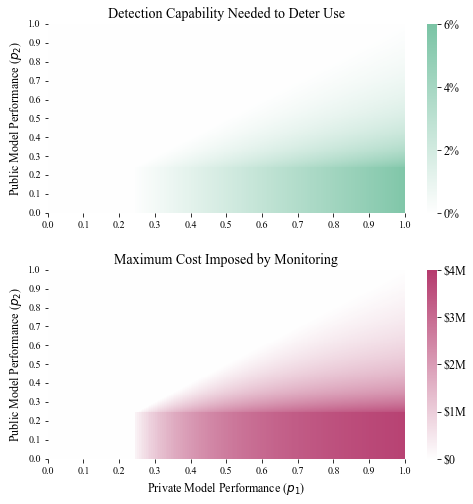

In [15]:
# Create a plot for Figure 4
fig, (ax0, ax1) = plt.subplots(nrows = 2, figsize = (8,8))

# Create two colormaps for shading in the figure
cmap_threshes = get_continuous_cmap(['#FFFFFF', colors[2]])
cmap_max_costs = get_continuous_cmap(['#FFFFFF', colors[1]])

# Plot the threshold detection rate as a heatmap, reversing the order of the y-axis (because sns.heatmap plots downward from the top of the axis by default)
sns.heatmap(threshes[::-1], ax = ax0, cmap = cmap_threshes, vmin = 0., vmax = 0.06)

# Plot the maximum imposed costs on the other plot (again reversing the oder of the y-axis)
sns.heatmap(max_costs[::-1], ax = ax1, cmap = cmap_max_costs, vmin = 0., vmax = 4e6)

# Label the color bar for the top plot
ax0.collections[0].colorbar.set_ticks([0., 0.02, 0.04, 0.06])
ax0.collections[0].colorbar.set_ticklabels(['0%', '2%', '4%', '6%'], fontsize = 12, fontname = 'Times New Roman')

# Label the color bar for the bottom plot
ax1.collections[0].colorbar.set_ticks([0, 1e6, 2e6, 3e6, 4e6])
ax1.collections[0].colorbar.set_ticklabels(['$0', '$1M', '$2M', '$3M', '$4M'], fontsize = 12, fontname = 'Times New Roman')

# Adjust the figure aesthetics
for ax in [ax0, ax1]:
    ax.set_yticks(np.arange(0, 201, step = 20))
    ax.set_yticklabels(['1.0','0.9','0.8','0.7','0.6','0.5','0.4','0.3','0.2','0.1','0.0'], fontsize = 10, fontname = 'Times New Roman')
    ax.set_ylabel('Public Model Performance ($p_2$)', fontsize = 12, fontname = 'Times New Roman')
    ax.set_xticks(np.arange(0, 201, step = 20))
    ax.set_xticklabels(['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'], rotation=0, fontsize = 10, fontname = 'Times New Roman')
ax1.set_xlabel('Private Model Performance ($p_1$)', fontsize = 12, fontname = 'Times New Roman')
ax0.set_title('Detection Capability Needed to Deter Use', fontsize = 14, fontname = 'Times New Roman')
ax1.set_title('Maximum Cost Imposed by Monitoring', fontsize = 14, fontname = 'Times New Roman')
plt.subplots_adjust(hspace = 0.3)

# Save and display the image
plt.savefig('figures/strategies.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()

From the paper: "For instance, if both models perform with p > 0.5, but the best available
public model consistently performs only 90% as well as the private model, then optimal detection capabilties (roughly, a 0.2% probability of detection per output) will impose under $250,000 in additional costs."

In [16]:
# If both models are better than p = 0.5, but the best public model is consistently only 90% as good as the best private model, what is the maximum expected cost imposition of monitoring controls?
for p1 in [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]:
    cost = calc_max_imposition(calc_threshold_detection_rate(p1, 0.9 * p1), p1)
    thresh = calc_threshold_detection_rate(p1, 0.9 * p1)
    print(f'Maximum cost imposition for p1 = {p1} and p2 = {round(0.9 * p1, 2)}: ${round(cost, 2)} (achieved with {round(100 * thresh, 2)}% probability of detection per output)')

Maximum cost imposition for p1 = 0.55 and p2 = 0.5: $239783.17 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.6 and p2 = 0.54: $219801.24 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.65 and p2 = 0.59: $202893.45 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.7 and p2 = 0.63: $188401.06 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.75 and p2 = 0.68: $175840.99 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.8 and p2 = 0.72: $164850.93 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.85 and p2 = 0.77: $155153.81 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.9 and p2 = 0.81: $146534.16 (achieved with 0.2% probability of detection per output)
Maximum cost imposition for p1 = 0.95

# Section 6: Fixed Costs Associated with Running and Training Local Language Models

There are no figures associated with this section. Instead this code works through the three scenarios provided in bullet points in the paper, performs the necessary algebraic manipulation to calculate the values of interest, and then quickly estimates them.

### Scenario 1

Suppose that ChatGPT-3.5 is capable of producing ``usable'' outputs for an operator at a rate of 0.85, but that ChatGPT-4 has a higher success rate of 1.0. Because ChatGPT-4 requires a \$20 monthly fee to access, while ChatGPT-3.5 does not, we can treat the penalty for detection from ChatGPT-4 as \$20 higher than the penalty for detection from ChatGPT-3.5 (but since both models are owned by the same entity, we can imagine that they use similar monitoring controls with similar detection rates). The propagandist is then indifferent between the two when:

$\frac{n}{p_{\text{ChatGPT-3.5}}} \left( \frac{w}{\alpha L} + IC + P \lambda \right) = \frac{n}{p_{\text{ChatGPT-4}}} \left( \frac{w}{\alpha L} + IC + (P + 20) \lambda \right) $

Rearranging this to solve for $\lambda$ yields: 

$p_{\text{ChatGPT-4}} \left( \frac{w}{\alpha L} + IC + P \lambda \right) = p_{\text{ChatGPT-3.5}} \left( \frac{w}{\alpha L} + IC + (P + 20) \lambda \right)$

$p_{\text{ChatGPT-4}} \left( \frac{w}{\alpha L} + IC + P \lambda \right) = p_{\text{ChatGPT-3.5}} \left( \frac{w}{\alpha L} + IC + P \lambda \right) + 20 p_{\text{ChatGPT-3.5}} \lambda$

$\Delta p \left( \frac{w}{\alpha L} + IC + P \lambda \right) = 20 p_{\text{ChatGPT-3.5}} \lambda$

$\Delta p \left( \frac{w}{\alpha L} + IC \right) = \lambda ( 20 p_{\text{ChatGPT-3.5}} - \Delta p P)$

$\lambda = \frac{\Delta p \left( \frac{w}{\alpha L} + IC \right)}{20 p_{\text{ChatGPT-3.5}} - \Delta p P}$

In [17]:
# Calculate the result
p_3_5 = 0.85
p_4 = 1.0
delta_p = p_4 - p_3_5
lambda_hat = delta_p * (w / (alpha * L) + IC) / (20 * p_3_5 - delta_p * penalty)
print('Detection rate to induce indifference between ChatGPT-3.5 and ChatGPT-4:', np.mean(lambda_hat, axis = 0))
print('Operator prefers ChatGPT-3.5 if the outputs per detection is less than:', 1 / np.mean(lambda_hat, axis = 0))

Detection rate to induce indifference between ChatGPT-3.5 and ChatGPT-4: 0.0009418399078943542
Operator prefers ChatGPT-3.5 if the outputs per detection is less than: 1061.7515690492164


### Scenario 2

Suppose further that OpenAI has in fact implemented monitoring controls sufficient to detect malicious action at this rate. However, the propagandist can also reach performance on par with ChatGPT-3.5 by expending only \$600 to download and fine-tune an existing public model, i.e. the point $(\$600, 0.85) \in FR$. The propagandist is then indifferent between the two when:

$\frac{n}{p_1} \left( \frac{w}{\alpha L} + IC + P \lambda \right) = \frac{n}{p_2} \left( \frac{w}{\alpha L} + IC \right) + FC$

Rearranging this to solve for $n$ yields: 

$n \cdot p_2 \left( \frac{w}{\alpha L} + IC \right) + n \cdot p_2 P \lambda = n \cdot p_1 \left( \frac{w}{\alpha L} + IC \right) + FC \cdot p_1 \cdot p_2$

$n \Delta p \left( \frac{w}{\alpha L} + IC \right) + n \cdot p_2 P \lambda = FC \cdot p_1 \cdot p_2$

$n = \frac{p_1 FC}{P \lambda}$ (Because $\Delta p$ in this scenario is 0)

In [18]:
# Solve and print 
print('Minimum number of outputs to prefer local model:', np.mean(p_3_5 * 600 / (penalty * lambda_hat), axis = 0))

Minimum number of outputs to prefer local model: 241088.51541357805


### Scenario 3

Finally, suppose that the propagandist cannot further improve any existing open source language models beyond this threshold with additional fine-tuning. However, the propagandist can choose to train a more advanced model of their own for \$4,600,000 which could perform as well as ChatGPT-4 (but without the restrictions on access). Then we can again find the point at which this becomes preferred to the OpenAI-controlled model: 

$\frac{n}{p_1} \left( \frac{w}{\alpha L} + IC + P \lambda \right) = \frac{n}{p_2} \left( \frac{w}{\alpha L} + IC \right) + FC$

Rearranging this to solve for $n$ yields: 

$n \Delta p \left( \frac{w}{\alpha L} + IC \right) + n \cdot p_2 P \lambda = FC \cdot p_1 \cdot p_2$

$n = \frac{FC \cdot p_1 \cdot p_2}{\Delta p \left( \frac{w}{\alpha L} + IC \right) + \cdot p_2 P \lambda}$

In [19]:
# Solve and print
denom = (p_4 - p_3_5) * (w / (alpha * L) + IC) + p_4 * penalty * lambda_hat
print('Minimum number of outputs to prefer model training from scratch over OpenAI models:', np.mean(4.6e6 * p_3_5 * p_4 / denom, axis = 0))

Minimum number of outputs to prefer model training from scratch over OpenAI models: 310718178.1130761


But at this scale, the use of the \$600-fine-tuned model is actually more economical, so we should compare those two options and solve for $n$ ($p_1$ now represents 0.85, achieved with \$600 of fine-tuning, and $p_2$ represents 1.0, achieved with \$4.6 million in training costs): 

$\frac{n}{p_1} \left( \frac{w}{\alpha L} + IC \right) + FC_1 = \frac{n}{p_2} \left( \frac{w}{\alpha L} + IC \right) + FC_2$

Rearranging this to solve for $n$ yields: 

$n \frac{p_2 - p_1}{p_2 \cdot p_1} \left( \frac{w}{\alpha L} + IC \right) = \Delta FC$

$n = \frac{\Delta FC \cdot p_1 \cdot p_2}{\Delta p \left( \frac{w}{\alpha L} + IC \right)}$

In [20]:
# Solve and print
denom = (p_4 - p_3_5) * (w / (alpha * L) + IC)
print('Minimum number of outputs to prefer model training from scratch over alternative open source models:', np.mean((4.6e6 - 600) * p_3_5 * p_4 / denom, axis = 0))

Minimum number of outputs to prefer model training from scratch over alternative open source models: 409223442.5598232


# Section 7: Sensitivity Analysis

The paper describes six precise variables of interest that are explicitly or implicitly estimated throughout the previous analysis. The goal of this figure is to estimate each of these, and show how they vary if only one of the five major Monte-Carlo-sampled parameters (alpha, w, L, IC, and P) is allowed to vary at a time. 

1. Write a function that can create a dictionary of parameter estimates, where only one specified parameter of interest is allowed to vary at a time.
2. Write functions for each of the six variables of interest, where the function takes a dictionary of parameters from the function created in step 1 and produces 10,000 estimates for the variable of interest using that dictionary.
3. Create a DataFrame for each of the six variables of interest and store the 10,000 estimates associated with varying one input parameter at a time in appropriate columns (also create a column to store estimates produced by randomly sampling all five major input parameters). 
4. Plot the results (Figure 5).
5. Calculate the mean of all estimates generated by varying ALL five input parameters to include in the text (note that although this is the LAST step here, these mean values are displayed FIRST within the relevant section of the paper).

In [21]:
# Create a function that initializes a dataframe to store the results of 10,000 samples holding all but one variable constant at a time
def create_df():
    return pd.DataFrame({var: [pd.NA] * N_SIMS for var in ['alpha', 'w', 'L', 'IC', 'P', 'All']})
    

# Create a function that returns parameter estimates, where all except the variable indicated are simply set to the midpoint of their sampling range
def get_param_estimates(var):
    full_simulated_values = {'w': w, 'alpha': alpha, 'L': L, 'IC': IC, 'P': penalty}
    params = {'w': 5.47, 'alpha': 6, 'L': 15, 'IC': 0.01, 'P': 6.84}  # Initialize the local array of parameters

    if var in ['w', 'alpha', 'L', 'IC']:  # Overwrite the relevant variable entry with the 10,000 estimates
        params[var] = full_simulated_values[var]  

        if var == 'w':  # Holding "P" constant means multiplying it by the constant value of 1.25, but P still depends on variability in w
            params['P'] = params['w'] * 1.25 
        return params

    elif var == 'P':  # Sampling from "P" means sampling the multiplier times w from the range (.5, 2), but the multiplier then stays constant
        params['P'] = np.random.uniform(0.5, 2, size = N_SIMS) * 5.47
        return params

    elif var == 'All':  # We also want to observe the variation if we don't hold any parameter estimates constant
        return full_simulated_values

    else: print('Please enter a valid variable or the word \'All\'')


In [22]:
# Create a function to estimate threshold performance and return 10,000 results
def estimate_thresh(params):
    return 1 / params['alpha'] + params['L'] * params['IC'] / params['w']  # From eq. 1


# Create a function to estimate maximum savings and return 10,000 results
def estimate_max_savings(params, p_ = 0.75, n_ = 1e7):
    manual_mc = params['w'] / params['L'] 
    ai_mc = (params['w'] / (params['alpha'] * params['L']) + params['IC']) / p_  # From eq. 1
    return np.log10((manual_mc - ai_mc) * n_)  # Return the log of average maximum savings


# Create a function to estimate optimal detection rate (API only) and return 10,000 results
def estimate_cost_api(params, p_ = 0.75):
    lambda_hat_estimates = 1 / params['P'] * (params['w'] * p_ / params['L'] - params['w'] / (params['alpha'] * params['L']) - params['IC'])  # From eq. 8
    return lambda_hat_estimates  


# Create a function to estimate maximum cost imposition (public option) and return 10,000 results
def estimate_cost_public(params, p1_ = 0.75, p2_ = 0.7, n_ = 1e7):
    mc = params['w'] / (params['alpha'] * params['L']) + params['IC']
    lambda_hat = mc * (p1_ - p2_) / p2_  # From eq. 9
    return np.log10(n_ * params['P'] * lambda_hat / p1_)  # Return the log of average cost imposition


# Create a function to estimate minimum viable size (fine-tuning) and return 10,000 results when the public, fine-tuned and private, monitored models have equivalent performances
def estimate_min_fine(params, p_ = 0.85, lambda_ = 0.001, FC_ = 600):
    denom = p_ * params['P'] * lambda_  # From eq. 10 (where p_hat == p_1)
    return np.log10(p_ * FC_ / denom)  # Return the log of average minimum viable scale


# Create a function to estimate minimum viable size (training) and return 10,000 results
def estimate_min_train(params, p1_ = 0.85, p2_ = 1.0, delta_FC = 4.6e6 - 600):
    denom = (p2_ - p1_) * (params['w'] / (params['alpha'] * params['L']) + params['IC'])  # From eq. 10
    return np.log10(p1_ * p2_ * delta_FC / denom)  # Return the log of average minimum viable scale

In [23]:
# Use create_df to initialize a df for each of the six point estimate results
results = {q: create_df() for q in ['thresh', 'max_savings', 'cost_api', 'cost_public', 'min_fine', 'min_train']}


# Loop over each parameter of interest and isolate the relevant variables 
for var in ['alpha', 'w', 'L', 'IC', 'P', 'All']:
    params = get_param_estimates(var)

    # Then loop over each df and the corresponding function and generate 10,000 estimates varying only the variable in question
    for df, func in zip(['thresh', 'max_savings', 'cost_api', 'cost_public', 'min_fine', 'min_train'], [estimate_thresh, estimate_max_savings, estimate_cost_api, estimate_cost_public, estimate_min_fine, estimate_min_train]):
        results[df][var] = func(params)


# Display the head of the first df (for estimates of the threshold value for p)
results['thresh'].head()

,alpha,w,L,IC,P,All
0,0.168165,0.200365,0.189469,0.215155,0.194089,0.190289
1,0.203654,0.183096,0.187980,0.180152,0.194089,0.182511
2,0.130345,0.187064,0.182248,0.190555,0.194089,0.113020
3,0.293959,0.190586,0.198011,0.210874,0.194089,0.310611
4,0.176613,0.222702,0.193234,0.199247,0.194089,0.213690


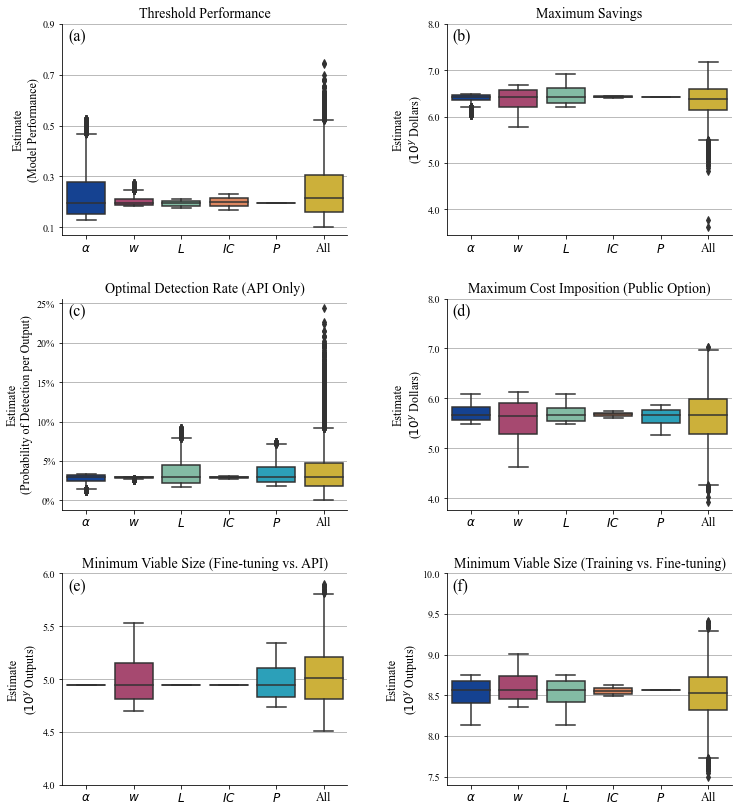

In [24]:
# Create a function that, for one of the six dfs again and an axis, plots the estimates as a boxplot
def format_boxplot(ax, data, label, inset):
    ax.set_axisbelow(True)
    g = sns.boxplot(data = data, ax = ax, order = ['alpha', 'w', 'L', 'IC', 'P', 'All'], palette = colors, zorder = 10)
    ax.set_xticklabels([r'$\alpha$', r'$w$', r'$L$', r'$IC$', r'$P$', 'All'], fontsize = 12, fontname = 'Times New Roman')
    ax.set_ylabel(f'Estimate{label}', fontsize = 12, fontname = 'Times New Roman')
    ax.set_xlim(-0.5, 5.5)
    ax.annotate(inset, xy = (0.02, 0.98), xycoords = 'axes fraction', ha = 'left', va = 'top', fontsize = 16, fontname = 'Times New Roman')

# Initialize the figure
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 14))
plt.subplots_adjust(wspace = 0.35, hspace = 0.3)

# Plot the first set of estimtes (from df `thresh`) and adjust aesthetics
format_boxplot(axes[0][0], results['thresh'], '\n(Model Performance)', '(a)')
axes[0][0].set_yticks(np.arange(0.1, 1.0, step = 0.2))
axes[0][0].set_yticklabels([str(round(i, 1)) for i in np.arange(0.1, 1.0, step = 0.2)], fontsize = 10, fontname = 'Times New Roman')
axes[0][0].set_title('Threshold Performance', fontsize = 14, fontname = 'Times New Roman')

# Plot the second set of estimtes (from df `max_savings`) and adjust aesthetics
format_boxplot(axes[0][1], results['max_savings'], '\n($10^y$ Dollars)', '(b)')
axes[0][1].set_yticks(np.arange(4., 9.))
axes[0][1].set_yticklabels([str(i) for i in np.arange(4., 9.)], fontsize = 10, fontname = 'Times New Roman')
axes[0][1].set_title('Maximum Savings', fontsize = 14, fontname = 'Times New Roman')

# Plot the third set of estimtes (from df `cost_api`) and adjust aesthetics
format_boxplot(axes[1][0], results['cost_api'], '\n(Probability of Detection per Output)', '(c)')
axes[1][0].set_yticks(np.arange(0.0, 0.3, step = 0.05))
axes[1][0].set_yticklabels([f'{int(100 * i)}%' for i in np.arange(0.0, 0.3, step = 0.05)], fontsize = 10, fontname = 'Times New Roman')
axes[1][0].set_title('Optimal Detection Rate (API Only)', fontsize = 14, fontname = 'Times New Roman')

# Plot the fourth set of estimtes (from df `cost_public`) and adjust aesthetics
format_boxplot(axes[1][1], results['cost_public'], '\n($10^y$ Dollars)', '(d)')
axes[1][1].set_yticks(np.arange(4., 9.))
axes[1][1].set_yticklabels([str(i) for i in np.arange(4., 9.)], fontsize = 10, fontname = 'Times New Roman')
axes[1][1].set_title('Maximum Cost Imposition (Public Option)', fontsize = 14, fontname = 'Times New Roman')

# Plot the fifth set of estimtes (from df `min_fine`) and adjust aesthetics
format_boxplot(axes[2][0], results['min_fine'], '\n($10^y$ Outputs)', '(e)')
axes[2][0].set_yticks(np.arange(4., 6.5, step = 0.5))
axes[2][0].set_yticklabels([str(i) for i in np.arange(4., 6.5, step = 0.5)], fontsize = 10, fontname = 'Times New Roman')
axes[2][0].set_title('Minimum Viable Size (Fine-tuning vs. API)', fontsize = 14, fontname = 'Times New Roman')

# Plot the sixth set of estimtes (from df `min_train`) and adjust aesthetics
format_boxplot(axes[2][1], results['min_train'], '\n($10^y$ Outputs)', '(f)')
axes[2][1].set_yticks(np.arange(7.5, 10.5, step = 0.5))
axes[2][1].set_yticklabels([str(i) for i in np.arange(7.5, 10.5, step = 0.5)], fontsize = 10, fontname = 'Times New Roman')
axes[2][1].set_title('Minimum Viable Size (Training vs. Fine-tuning)', fontsize = 14, fontname = 'Times New Roman')

# Make final figure adjustments and save the resulting figure
plt.savefig('figures/sensitivity.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()

In [25]:
# Plot the average result for each of the six variables of interest
for key in results.keys():
    if key in {'thresh', 'cost_api'}: 
        print(f'Mean value for {key}:', results[key]['All'].mean())  # For these variables, results were stored directly
        print(f'95% CI for {key}: [', results[key]['All'].quantile(0.025), 
            ',', results[key]['All'].quantile(0.975), ']')
    else:
        print(f'Mean value for {key}:', (10 ** results[key]['All']).mean())  # Results were stored as the log for other variables
        print(f'95% CI for {key}: [', 10 ** results[key]['All'].quantile(0.025), 
            ',', 10 ** results[key]['All'].quantile(0.975), ']')
    print('——————————')

Mean value for thresh: 0.2457345814642049
95% CI for thresh: [ 0.11654571579363482 , 0.507273793814272 ]
——————————
Mean value for max_savings: 3016250.4080993193
95% CI for max_savings: [ 428884.6530063403 , 9402748.141123135 ]
——————————
Mean value for cost_api: 0.0380276234998991
95% CI for cost_api: [ 0.009022893374526813 , 0.11581389216314326 ]
——————————
Mean value for cost_public: 738202.3142966544
95% CI for cost_public: [ 43801.051450224215 , 3021543.1452057874 ]
——————————
Mean value for min_fine: 131932.41491621203
95% CI for min_fine: [ 38080.40158620957 , 422384.5531359463 ]
——————————
Mean value for min_train: 409223442.55982375
95% CI for min_train: [ 81657507.59810472 , 1126990611.0075097 ]
——————————
